In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

from ssd_model import SSD300
from ssd_data import InputGenerator
from ssd_utils import PriorUtil
from ssd_metric import confusion_matrix, plot_confusion_matrix, accuracy, evaluate_results

Using TensorFlow backend.


In [2]:
from data_voc import GTUtility
gt_util = GTUtility('data/VOC2012test/')

model = SSD300(num_classes=gt_util.num_classes)
model.load_weights('models/ssd300_voc_weights_fixed.hdf5', by_name=True)

priors_util = PriorUtil(model)

In [3]:
inputs, data = gt_util.sample_batch(gt_util.num_samples, 0, input_size=model.image_size)

preds = model.predict(inputs, batch_size=1, verbose=1)

5138/5138 [==============================] - 73s 14ms/step


### Confusion matrix of local predictions

100%|██████████| 5138/5138 [00:05<00:00, 945.52it/s]


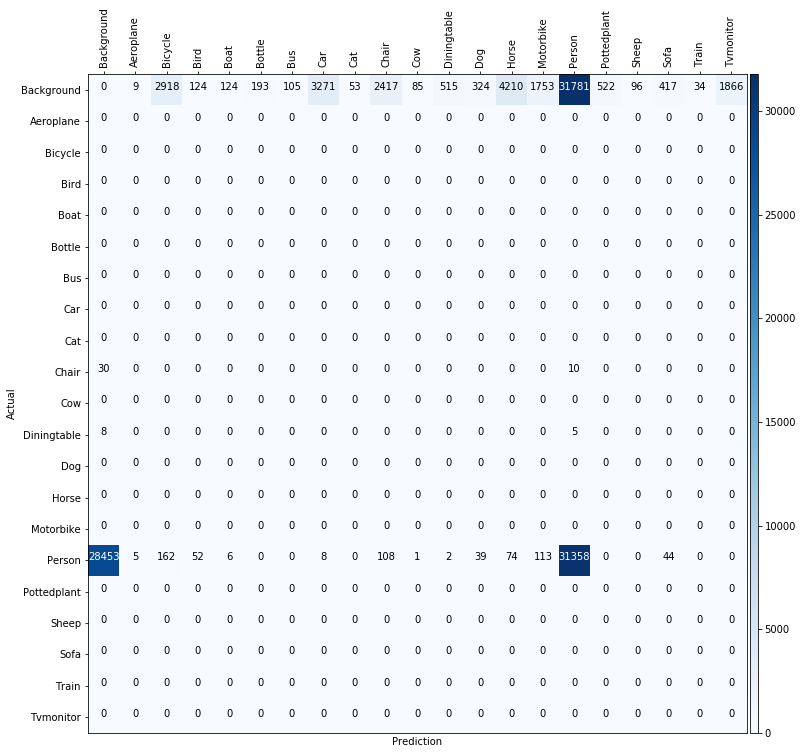

0.28175569432589065

In [4]:
results = [priors_util.decode(p, confidence_threshold=0.8) for p in tqdm(preds)]
encoded_gt = [priors_util.encode(d) for d in tqdm(data)]

y_true_all = []
y_pred_all = []

for i in range(len(data)):
    y_true = np.argmax(encoded_gt[i][:,4:], axis=1)
    y_pred = np.argmax(preds[i][:,4:], axis=1)
    #prior_object_idx = np.where(y_true)[0] # gt prior box contains object
    prior_object_idx = np.where(y_true+y_pred)[0] # gt or prediction prior box contains object
    y_true_all.extend(y_true[prior_object_idx])
    y_pred_all.extend(y_pred[prior_object_idx])
    
#y_pred_all = [ 17 for i in y_pred_all]

cm = confusion_matrix(y_true_all, y_pred_all, gt_util.num_classes)
plot_confusion_matrix(cm, gt_util.classes, figsize=[12]*2)
accuracy(y_true_all, y_pred_all)

### Precision-recall curve, mean Average Precision

100%|██████████| 5138/5138 [00:02<00:00, 1804.64it/s]


Class                     TP       FP       FN     AP
 1 Aeroplane               0       88        0    nan
 2 Bicycle                 0      960        0    nan
 3 Bird                    0      320        0    nan
 4 Boat                    0      276        0    nan
 5 Bottle                  0      779        0    nan
 6 Bus                     0      118        0    nan
 7 Car                     0     1449        0    nan
 8 Cat                     0       71        0    nan
 9 Chair                   1     2449        1  0.001
10 Cow                     0      123        0    nan
11 Diningtable             0      472        2  0.000
12 Dog                     0      302        0    nan
13 Horse                   0      867        0    nan
14 Motorbike               0      562        0    nan
15 Person               6896    19232      430  0.702
16 Pottedplant             0      782        0    nan
17 Sheep                   0       76        0    nan
18 Sofa                    0

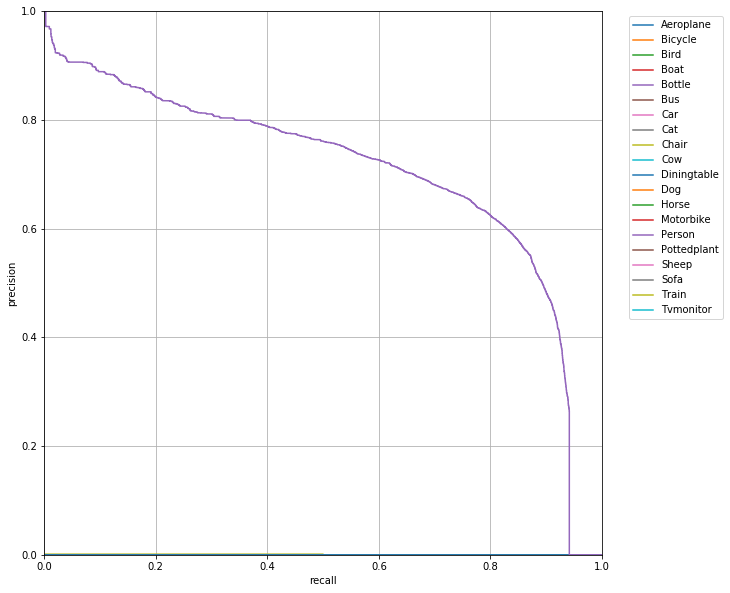

In [5]:
results = [priors_util.decode(p, confidence_threshold=0.1) for p in tqdm(preds)]
evaluate_results(data, results, gt_util, iou_thresh=0.5, max_dets=100)

### Examples

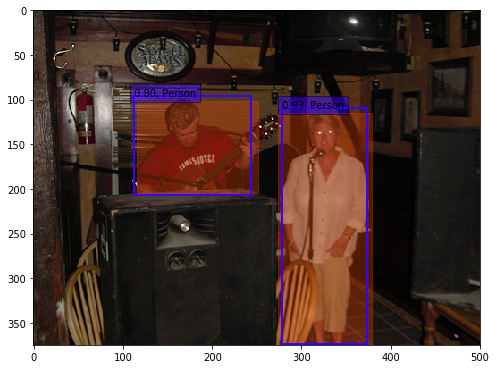

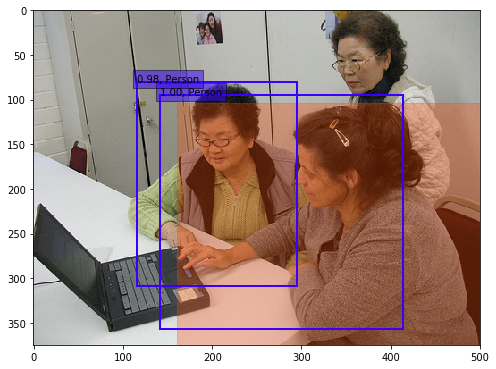

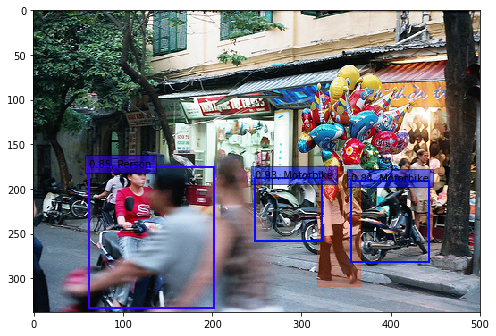

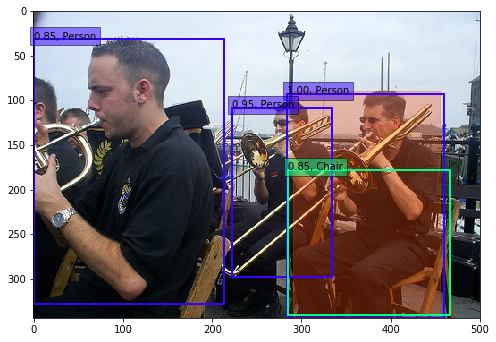

In [6]:
for i in np.random.randint(0, len(inputs), 4):
    _, img, _ = gt_util.sample(i)
    plt.figure(figsize=[8]*2)
    plt.imshow(img)
    priors_util.plot_results(results=results[i], classes=gt_util.classes, gt_data=data[i], confidence_threshold=0.8)
    plt.show()

### Grid search

In [7]:
steps = np.arange(0.05, 1, 0.05)

fmes_grid = np.zeros((len(steps)))

for i, t in enumerate(steps):
    results = [priors_util.decode(p, t) for p in preds]
    fmes = evaluate_results(data, results, gt_util, iou_thresh=0.5, max_dets=100, return_fmeasure=True)
    fmes_grid[i] = fmes
    print('threshold %.2f f-measure %.2f' % (t, fmes))

threshold 0.05 f-measure 0.17
threshold 0.10 f-measure 0.31
threshold 0.15 f-measure 0.39
threshold 0.20 f-measure 0.44
threshold 0.25 f-measure 0.48
threshold 0.30 f-measure 0.51
threshold 0.35 f-measure 0.53
threshold 0.40 f-measure 0.55
threshold 0.45 f-measure 0.57
threshold 0.50 f-measure 0.58
threshold 0.55 f-measure 0.59
threshold 0.60 f-measure 0.60
threshold 0.65 f-measure 0.61
threshold 0.70 f-measure 0.61
threshold 0.75 f-measure 0.62
threshold 0.80 f-measure 0.62
threshold 0.85 f-measure 0.61
threshold 0.90 f-measure 0.60
threshold 0.95 f-measure 0.58


0.8 0.6204976706706332


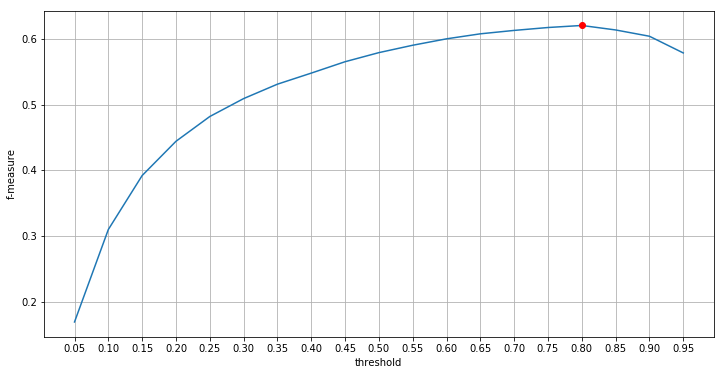

In [8]:
max_idx = np.argmax(fmes_grid)
print(steps[max_idx], fmes_grid[max_idx])
plt.figure(figsize=[12,6])
plt.plot(steps, fmes_grid)
plt.plot(steps[max_idx], fmes_grid[max_idx], 'or')
plt.xticks(steps)
plt.grid()
plt.xlabel('threshold')
plt.ylabel('f-measure')
plt.show()